In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fourth order well balanced MUSCL reconstruction

* Implementation of the fourth order well-balanced scheme
* For details on the scheme see [nswe_muscl_4order.ipynb](nswe_muscl_4order.ipynb) and [nswe_muscl_4order_reconstruct_u.ipynb](nswe_muscl_4order_reconstruct_u.ipynb)
* No slope limiters are used
* Well-balanced using hydrostatic reconstruction and second order discretization of source term
* Variables $h$ and $u$ are used as input
* Test cases at the end of the notebook

In [2]:
%%writefile nswe_wbmuscl4.py

import numpy as np
g = 9.81

import numpy as np
def roe(hl, ul, hr, ur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print 'negative h :(, hl,hr=%.3f,%.3f'%(hl,hr)

    if hl<1e-5 and hr <1e-5:
        return 0.0, 0.0
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    #print hs,us
    return hs,us

Overwriting nswe_wbmuscl4.py


In [3]:
%%writefile nswe_wbmuscl4.py -a

import numpy as np

def getSlopesReconstruction(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        
        -3 -2 -1  0  1  ...    nx   nx+1  nx+2  nx+3
        ---3---  --------nx-------   ------3--------        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx

    dhil = np.zeros((nx+2,))
    dhir = np.zeros((nx+2,))
    dhplus = np.zeros((nx+2,))
    dhminus = np.zeros((nx+2,))
    for i in range(2,nx+3+1):
        dhir[i-2] = (1.-nu)*(h[i+1]-h[i])+\
                    nu*(h[i]-h[i-1]) + \
                    xic*(-h[i-1] + 3.*h[i] -  3.*h[i+1] + h[i+2]) +\
                    xid*(-h[i-2] + 3.*h[i-1] -3.*h[i] +h[i+1])
        dhil[i-2] = (1.-nu)*(h[i] - h[i-1]) +\
                    nu*(h[i+1] - h[i]) + \
                    xic*(-h[i-2] +3.*h[i-1] -3.*h[i] +h[i+1]) + \
                    xid*(-h[i-1] + 3.*h[i] - 3.*h[i+1] + h[i+2])
        
        dhplus[i-2] = h[i+1] - h[i]
        
        dhminus[i-2] = h[i] - h[i-1]
        
    return dhil, dhir, dhplus, dhminus

Appending to nswe_wbmuscl4.py


In [4]:
%%writefile nswe_wbmuscl4.py -a


def getSlopesReconstruction_2(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        ---3---  --------nx-------   ------3--------        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    

    dhil = (1.-nu)*(h[j0:jf]-h[j0-1:jf-1]) +\
        nu*(h[j0+1:jf+1]-h[j0:jf]) + \
        xic*(-h[j0-2:jf-2] +3.*h[j0-1:jf-1] -3.*h[j0:jf] + h[j0+1:jf+1])+\
        xid*(-h[j0-1:jf-1] +3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2])
        
    dhir = (1.-nu)*(h[j0+1:jf+1])-h[j0:jf] +\
            nu*(h[j0:jf]-h[j0-1:jf-1]) +\
            xic*(-h[j0-1:jf-1] + 3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2]) +\
            xid*(-h[j0-2:jf-2] + 3.*h[j0-1:jf-1] - 3.*h[j0:jf] + h[j0+1:jf+1])
        
    
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

Appending to nswe_wbmuscl4.py


In [5]:
%%writefile nswe_wbmuscl4.py -a

def getSlopesReconstruction_3(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    
    dhil = h[j0-2:jf-2]*(-xic) + \
        h[j0-1:jf-1]*(-1.0*(1.0-nu) + 3.0*xic - xid)+ \
        h[j0:jf]*(1.0-2.*nu - 3.*xic + 3.*xid) + \
        h[j0+1:jf+1]*(nu + xic -3.*xid) + \
        h[j0+2:jf+2]*(xid)
        
    dhir = h[j0-2:jf-2]*(-xid) + \
        h[j0-1:jf-1]*(-nu-xic+3*xid) +\
        h[j0:jf]*(-(1.-2.*nu) + 3.*xic - 3.*xid) + \
        h[j0+1:jf+1]*(1.-nu -3.*xic + xid) + \
        h[j0+2:jf+2]*(xic)   
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

Appending to nswe_wbmuscl4.py


In [6]:
%%writefile nswe_wbmuscl4.py -a

def L(u,v,w):
    """
        u,v,w scalars
    """
    if u*v<=0:
        return 0.0
    else:
        return np.sign(u)*np.min([2.*np.abs(u),2.*np.abs(v),w])

Lvec = np.vectorize(L)    

Appending to nswe_wbmuscl4.py


* Fourth order reconstruction according to the paper of Bonneton et al. 2011.

In [7]:
%%writefile nswe_wbmuscl4.py -a

def minmod(slope1, slope2):
    if (slope1>0 and slope2 > 0):
        return min(slope1,slope2)
    if (slope1<0 and slope2<0):
        return max(slope1,slope2)
    return 0.
minmod = np.vectorize(minmod)

def get4thMusclLimitedReconstruction(h):
    """
       Receives 1D array of size nx+6 and returns
       1d arrays hirL and hilL of size nx+1 with values
       of the 4th order MUSCL reconstruction for cells
       i= -1 ... nx
    """
    nu = 1.0/3.0
    xic = -1.0/10.0
    xid = -1.0/15.0

    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = (nx+3) +1 #i=nx, +1 for python weird indexing

    
    # ----- Second order MUSCL scheme (for debugging - compare with the 4th order)    
#     s1 = h[j0+1:jf+1]-h[j0:jf]
#     s2 = h[j0:jf] - h[j0-1:jf-1]
#     s = minmod(s1, s2)
    
#     hirL = h[j0:jf] + 0.5*s
#     hilL = h[j0:jf] - 0.5*s
    
    
    # ---- Furth order MUSCL scheme 
    
    dhil, dhir, dhplus, dhminus = getSlopesReconstruction(h,nu,xic,xid)

#     Lir = Lvec(dhminus, dhplus, dhir)
#     Lil = Lvec(dhplus, dhminus, dhil)
    Lir = dhir
    Lil = dhil

    hirL = h[j0:jf] + 0.5*Lir
    hilL = h[j0:jf] - 0.5*Lil
    return hilL, hirL

Appending to nswe_wbmuscl4.py


## Hydrostatic reconstruction
* Interface topography values are defined as $$d_{i+1/2} = max(d_{i,r}, d_{i+1,l})$$
* And water height at each side of interfaces as

$$h_{i+1/2-} = max(0, h_{i,r} +d_{i,r} - d_{i+1/2})$$
  $$h_{i+1/2+} = max(0, h_{i+1,l}+d_{i+1,l}-d_{i+1/2})$$
  
* Finally, conserved values at each side of the interface

$$ U_{i+1/2-} = (h_{i+1/2-}, h_{i+1/2-} u_{i,r})^t$$
$$ U_{i+1/2+} = (h_{i+1/2+}, h_{i+1/2+} u_{i+1,l})^t$$

In [8]:
%%writefile nswe_wbmuscl4.py -a

def getHydrReconstr(dl,dr,hl,hr,ul,ur):
    """
        Receives values d_il, d_ir, h_il, h_ir, etc,
        in arrays dl,dr,hl,hr,ul,ur of size (nx+2) 
        (nx + 2 ghost cells)
        and calculates the hydrostatic reconstruction
        for h_{i+1/2^+} and h_{i+1/2-}.
        
        i goes from 2 to nx+3, for both input and output
        
        0, 1, 2, (3, 2, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = dl.shape[0]-2
    dinter = np.zeros((nx+1,))
    hp = np.zeros((nx+1,))
    up = np.zeros((nx+1,))
    hm = np.zeros((nx+1,))
    um = np.zeros((nx+1,))

    dinter = np.maximum(dr[:-1],dl[1:])
    hm = np.maximum(0., hr[:-1]+dr[:-1]-dinter)
    hp = np.maximum(0., hl[1:]+dl[1:]-dinter)
#     hum = np.where(hr[:-1]>0,hm*hur[:-1]/hr[:-1],0.)
#     hup = np.where(hl[1:]>0,hp*hul[1:]/hl[1:],0.)
    um = ur[:-1]
    up = ul[1:]
    return dinter, hm, hp, um, up

Appending to nswe_wbmuscl4.py


## Sources balancing and interface fluxes

The interface fluxes are calculated as

$$F_{i+1/2}^- = F^*_{i+1/2} + S_{i+1/2-}$$
$$F_{i+1/2}^+ = F^*_{i+1/2} + S_{i+1/2+}$$

where $$F^*_{i+1/2} = \mathcal{F}(U^*_{i+1/2}(0, U_{i+1/2-}, U_{i+1/2+})$$ with $U^*(t,U_l,U_r)$ is the operator that solves the homogeneous Riemann problem for a given $t$ between states $U_l$ and $U_r$ and $\mathcal{F}(U)$ is the interface flux function

additionally

$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$
$$S_{i-1/2+} = \left(0, \frac{g}{2}(h_{i,l}^2 -h_{i-1/2+}^2)\right)^t$$

or better using $i+1/2\pm$
$$S_{i+1/2+} = \left(0, \frac{g}{2}(h_{i+1,l}^2 -h_{i+1/2+}^2)\right)^t$$
$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$

Given these definitions the semidiscrete system is

$$ \Delta x \frac{d}{dt} U_{i}(t) + (F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

where $$S_{c,i} = \left( 0, g\frac{h_{i,l}+h_{i,r}}{2}(d_{i,l}-d_{i,r}) \right)^T $$

In [9]:
%%writefile nswe_wbmuscl4.py -a

def sources(dl,dr,hl,hr,hp,hm):
    sp = np.zeros((2,hl[1:].shape[0]))
    sm = np.zeros((2,hm.shape[0]))
    sc = np.zeros((2,dl.shape[0]))
    sp[1,:] = 0.5*g*(hl[1:]**2-hp**2) #S_{i+1/2+}   
    sm[1,:] = 0.5*g*(-hm**2+hr[:-1]**2)    #S_{i+1/2-}
    sc[1,:] = 0.5*g*(hl+hr)*(dl-dr) #S_{c,i}
    return sp, sm, sc

Appending to nswe_wbmuscl4.py


In [10]:
%%writefile nswe_wbmuscl4.py -a

def flux(h,u):
    """
        Receives scalars h,u
        Returns array F(u) of size 2
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

Appending to nswe_wbmuscl4.py


In [11]:
%%writefile nswe_wbmuscl4.py -a

def fluxes_sources(d,hn,un,riemann_solver=roe,hmin=1e-10):
    """
        Receives 1D arrays h and u (1,nx+6)
        and returns array of fluxes (2,nx+1) for
        left and right interfaces of cells 
        0 to nx (total of nx+1)
    """
    nx = hn.shape[0]-6
    fs = np.zeros((2,nx+1))
    fp = np.zeros((2,nx+1))
    fm = np.zeros((2,nx+1))
    
    Lhl, Lhr = get4thMusclLimitedReconstruction(hn)
#     Lul, Lur = get4thMusclLimitedReconstruction(un)    
    Lhul, Lhur = get4thMusclLimitedReconstruction(un*hn)
    Lul = np.where(Lhl>1e-5, Lhul/Lhl, 0.0)
    Lur = np.where(Lhr>1e-5, Lhur/Lhr, 0.0)    

    LHl, LHr = get4thMusclLimitedReconstruction(hn+d)
    Ldl = LHl - Lhl
    Ldr = LHr - Lhr

    dinter, hm, hp, um, up = getHydrReconstr(Ldl,Ldr,Lhl,Lhr,Lul,Lur)    
    sp, sm, sc = sources(Ldl,Ldr,Lhl,Lhr,hp,hm)
    

    fs = np.zeros((2,nx+1))
    for i in range(nx+1):
        hs,us = riemann_solver(hm[i],um[i],hp[i],up[i])
        fs[:,i] = flux(hs,us)
        
    fp = fs + sp
    fm = fs + sm
    return fp, fm, sc

Appending to nswe_wbmuscl4.py


## Simple boundary conditions

In [12]:
%%writefile nswe_wbmuscl4.py -a

def bcs_closed(d0,h0,u0,*args):
    """ 
        receives matrices h,u (,nx+6) 
        to assign ghost cell values that simulate a 
        closed boundary: homogeneous Neumann on h
        and homogeneous Dirichlet on u.
        Returns new arrays h, u of size (,nx+6) 
        on which the boundary conditions have been applied
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h.shape[0]-6
    j0 = 3
    jf = nx+2
    
    hb = np.copy(h0)
    ub = np.copy(u0)
    db = np.copy(d0)
    
    for k in range(1,4):
        #homogeneous neumann h
        db[j0-k] = db[j0+k-1]
        db[jf+k] = db[jf-k+1]
        
        
        #homogeneous neumann h
        hb[j0-k] = hb[j0+k-1]
        hb[jf+k] = hb[jf-k+1]
        
        #homogeneous dirichlet hu
        ub[j0-k] = -ub[j0+k-1]
        ub[jf+k] = -ub[jf+k-1]
    return hb,ub

Appending to nswe_wbmuscl4.py


In [13]:
%%writefile nswe_wbmuscl4.py -a

def bcs_open(d0,h0,u0,*args):
    """ 
        receives matrices h,u (,nx+6) 
        to assign ghost cell values that simulate a 
        closed boundary: homogeneous Neumann on h
        and homogeneous Neumann on u.
        Returns new arrays h, u of size (,nx+6) 
        on which the boundary conditions have been applied
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h0.shape[0]-6
    j0 = 3
    jf = nx+2
    
    hb = np.copy(h0)
    ub = np.copy(u0)
    db = np.copy(d0)
    
    for k in range(1,4):
        #homogeneous neumann h
        db[j0-k] = db[j0+k-1]
        db[jf+k] = db[jf-k+1]        
        
        #homogeneous neumann h
        hb[j0-k] = hb[j0+k-1]
        hb[jf+k] = hb[jf-k+1]
        
        #homogeneous dirichlet hu
        ub[j0-k] = ub[j0+k-1]
        ub[jf+k] = ub[jf+k-1]
    return db,hb,ub

Appending to nswe_wbmuscl4.py


## Time evolution functions

In [14]:
%%writefile nswe_wbmuscl4.py -a

def setdt(h0,u0,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    s = np.max(np.abs(u0)+np.sqrt(9.81*h0))
    dt = cfl*dx/s
    return dt

Appending to nswe_wbmuscl4.py


In [15]:
%%writefile nswe_wbmuscl4.py -a

def step(d, h0,u0,dx, bcs, riemann_solver, bcargs=[], hmin=1e-10):
    nx = h0.shape[0]-6
    h0 = np.where(h0<=hmin,hmin,h0)
    u0 = np.where(h0<=hmin,0.0,u0)    
    h0 = np.where(np.isnan(h0),0.0,h0)
    u0 = np.where(np.isnan(h0),0.0,u0)
    
    d, h0, u0 = bcs(d, h0,u0,*bcargs)
    
    fp, fm, sc = fluxes_sources(d,h0,u0,riemann_solver)
        
    F = np.zeros((2,nx+6))
    F[0,3:-3] = -1./dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]*1./dx
    F[1,3:-3] = -1./dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]*1./dx   
    
    return d, h0, u0, F

Appending to nswe_wbmuscl4.py


In [16]:
%%writefile nswe_wbmuscl4.py -a

def solve_euler(d0,h0,u0,bcs,dx,cfl,t0,nt,tol,riemann_solver,bcargs=[]):
    """
        Main routine that runs the simulation.
        INPUT:
        h,hu: numpy arrays (nt,nx+6) to store the solution.
             Must have the initial condition defined on the 
             first row.
        dx: cell size
        cfl: CFL number for time step
        t0: starting time of the simulation
        nt: number of time steps desired for the simulation
        tol: tolerance for dry bottom
    """
    nx = h0.shape[0]
    d = np.zeros(nx+6)
    h = np.zeros((nt,nx+6))
    u = np.zeros((nt,nx+6))
    h[0,3:-3] = h0
    u[0,3:-3] = u0
    
    t = np.zeros((nt,))
    t[0] = t0
    

    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt

        F = step(d, h[n,:],u[n,:], dx, bcs, riemann_solver,
                 bcargs=bcargs,hmin=tol)
        
        h[n+1,:] = h[n,:] + F[0,:]*dt
        hu = h[n,:]*u[n,:] + F[1,:]*dt        
        u[n+1,:] = np.where(h[n+1,:]>tol, hu/h[n+1,:], 0.0)
        
    return t,h[:,3:-3],u[:,3:-3]

Appending to nswe_wbmuscl4.py


In [17]:
%%writefile nswe_wbmuscl4.py -a

def solve_rk4(d0,h0,u0,bcs,dx,cfl,t0,nt,tol,riemann_solver,bcargs=[]):
    """
        Main routine that runs the simulation, using a 4th order
        Runge Kutta scheme for time integration
    """
    nx = h0.shape[0]
    d = np.zeros(nx+6)
    h = np.zeros((nt,nx+6))
    u = np.zeros((nt,nx+6))
    d[3:-3] = d0
    h[0,3:-3] = h0
    u[0,3:-3] = u0
    
    t = np.zeros((nt,))
    t[0] = t0
    

    for n in range(nt-1):
        dt = setdt(h[n,:],u[n,:],dx,cfl)
        t[n+1] = t[n] + dt
        
        h1 = h[n,:]
        u1 = u[n,:]
        d, h1, u1, k1 = step(d, h1, u1, dx, bcs, riemann_solver,
                         bcargs=bcargs+[t[n],0.5*dt],hmin=tol)
        h[n,:] = h1
        u[n,:] = u1
        
        h2 = h[n,:] + 0.5*dt*k1[0,:]
        u2 = np.where( h2>tol, (h[n,:]*u[n,:]+0.5*k1[1,:]*dt)/h2, 0.0)
        d, h2, u2, k2 = step(d, h2, u2, dx, bcs, riemann_solver,
                         bcargs=bcargs+[t[n],0.5*dt],hmin=tol)
        
        h3 = h[n,:] + 0.5*dt*k2[0,:]
        u3 = np.where( h3>tol, (h[n,:]*u[n,:]+0.5*k2[1,:]*dt)/h3, 0.0)
        d, h3, u3, k3 = step(d, h3, u3, dx, bcs, riemann_solver,
                         bcargs=bcargs+[t[n]+0.5*dt,0.5*dt],hmin=tol)        
        
        h4 = h[n,:] + k3[0,:]*dt
        u4 = np.where(h4>tol, (h[n,:]*u[n,:]+k3[1,:]*dt)/h4, 0.0)
        d, h4, u4, k4 = step(d, h4, u4, dx, bcs, riemann_solver,
                         bcargs=bcargs+[t[n]+0.5*dt,0.5*dt],hmin=tol)
        
        h[n+1,:] = h[n,:] + dt/6.*(k1[0,:]+2.*k2[0,:]+2.*k3[0,:]+k4[0,:])
        hu = h[n,:]*u[n,:] + dt/6.*(k1[1,:]+2.*k2[1,:]+2.*k3[1,:]+k4[1,:])
        u[n+1,:] = np.where(h[n+1,:]>tol, hu/h[n+1,:], 0.0)
        
    return t,h,u

Appending to nswe_wbmuscl4.py


Una iteración

# Test cases

## Lake at rest

From Berthon and Marche (2008), section 6.3.

The topography is defined by

$$ d(x,y)  = \begin{cases}
0.2 - 0.05(x-10)^2 & \text{ if } 8m < x < 12m \\
0 & \text{ else}
\end{cases}$$

and the water level is set to $0.1m$

In [18]:
import nswe_wbmuscl4 as wb4

### Simulation setup

In [19]:
nt = 100*4
nx = 100
cfl = 0.1
t0 = 0.0

In [20]:
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]
d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)*0.1*2
# d0 = np.where((x>8)*(x<12),0.02,0.0)*4
h0 = np.where(0.1-d0>=0, 0.1-d0, 0.0)
# h0 = np.where(np.abs(x-10.0)<=5,np.exp(-(x-10)**2/2**2)*0.1/10+0.1,0.1)
# h0 = np.cos((x-10)*2*np.pi/10.)*0.5+1.0
u0 = np.zeros_like(h0)

d0 = np.where((x<=2),1.0,0.0)
d0 = np.where((x>=24),1.0,d0)
h0 = np.where(x<=10,0.15-d0,0.15)
h0 = np.where(h0<=0.0,0.0,h0)

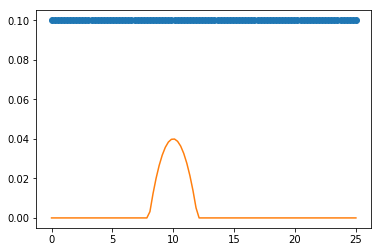

In [21]:
plt.plot(x,h0+d0,'o')
plt.plot(x,d0)

### Run the simulation and plot results

In [22]:
t1,h1,u1 = wb4.solve_rk4(d0,h0,u0,wb4.bcs_open,dx,cfl,t0,nt,1e-10,wb4.roe)


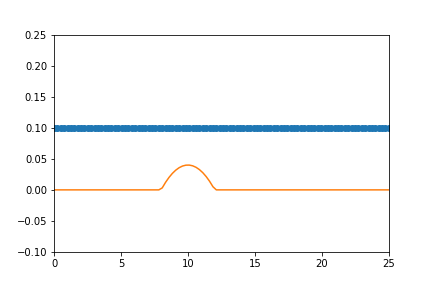
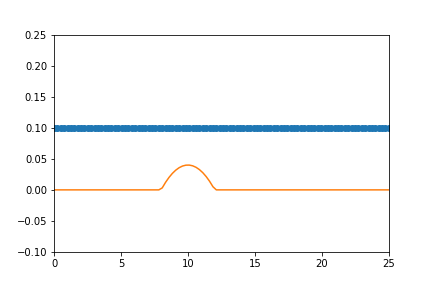
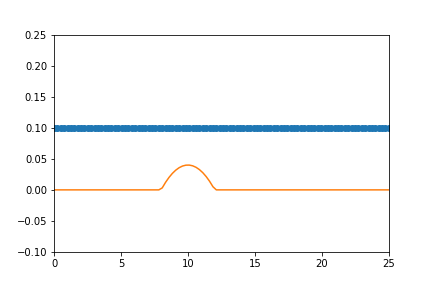
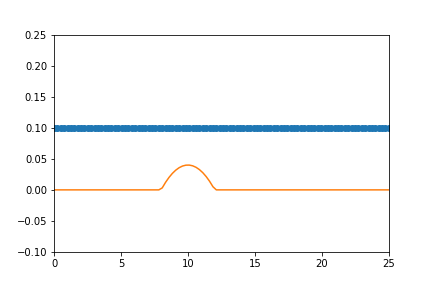
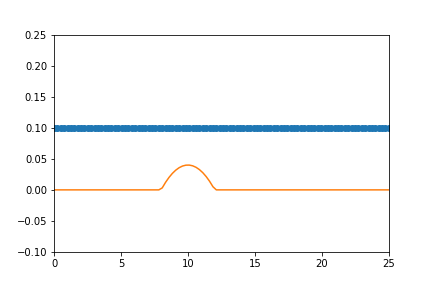
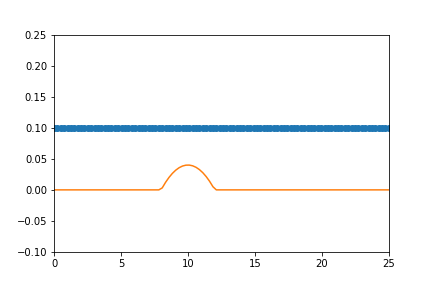
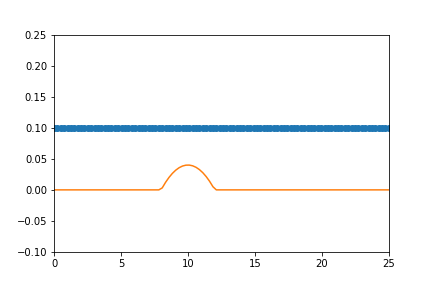
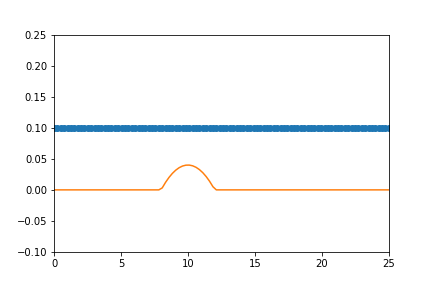
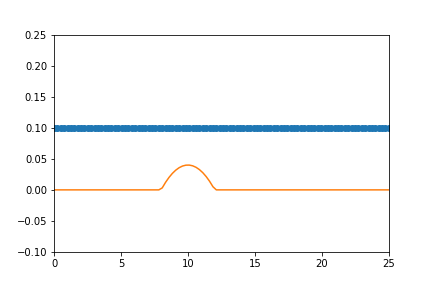
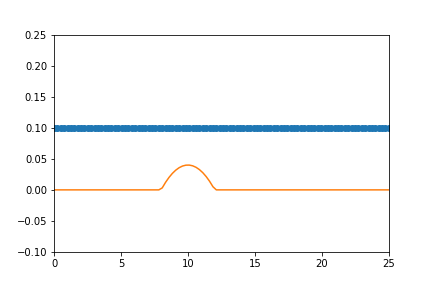
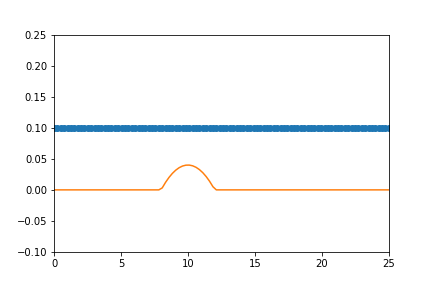
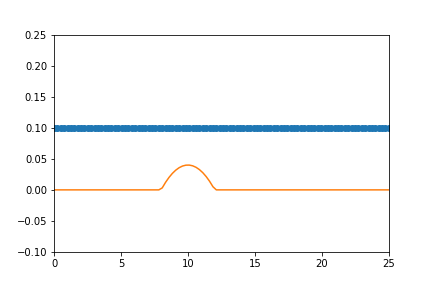
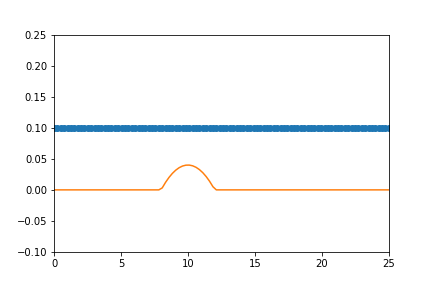
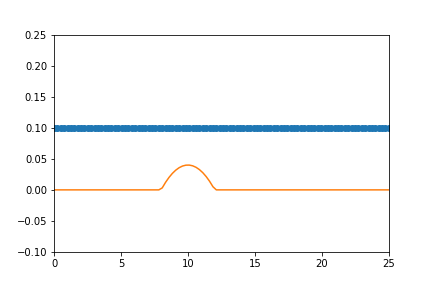
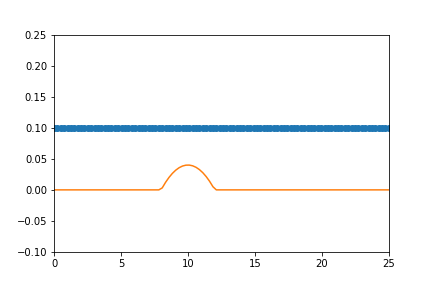
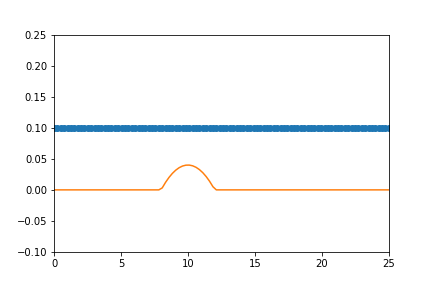
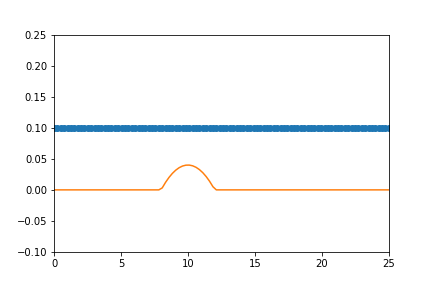
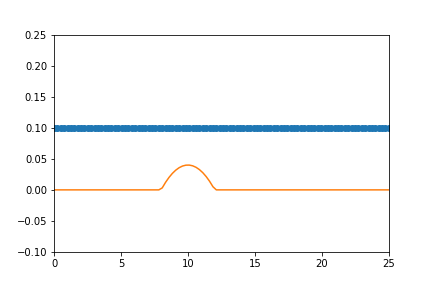
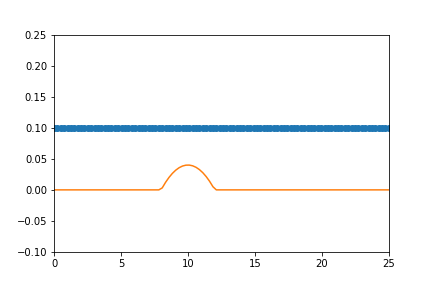
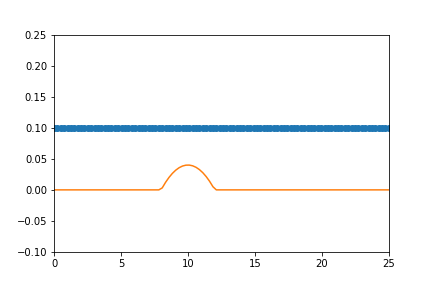
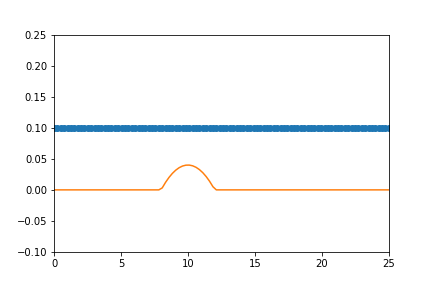
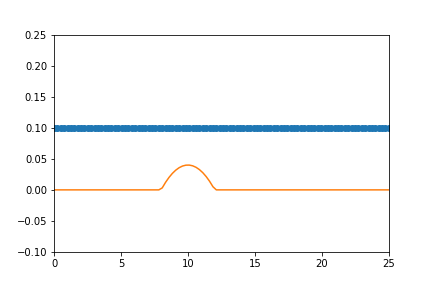
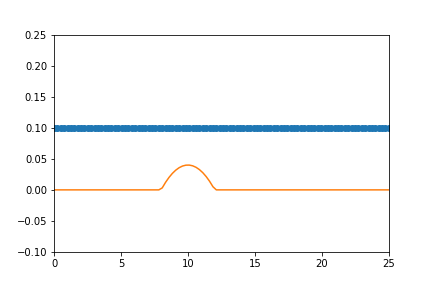
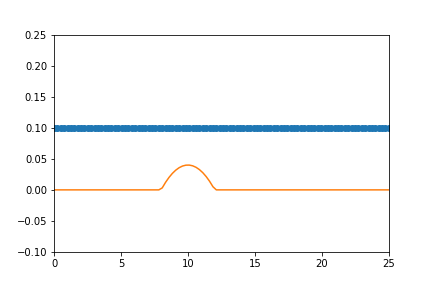
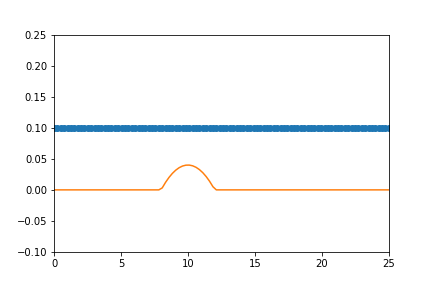
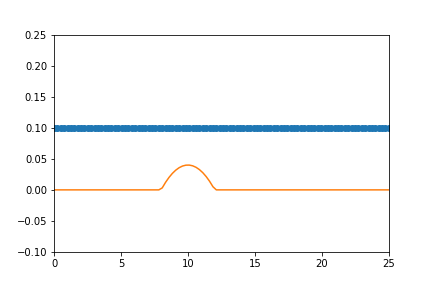
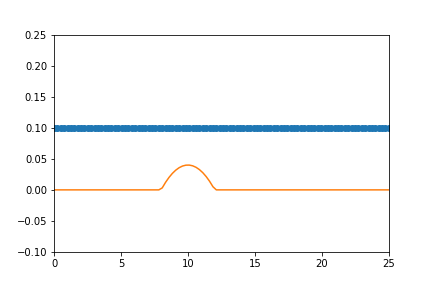
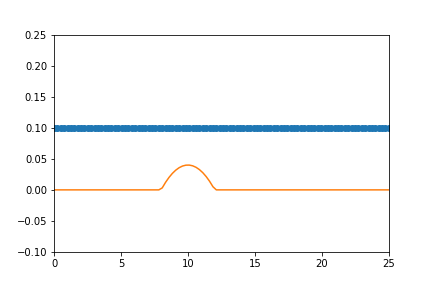
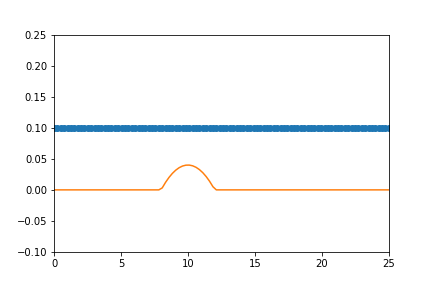
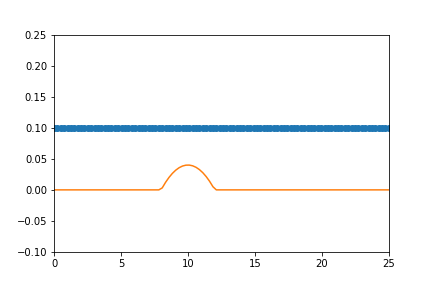
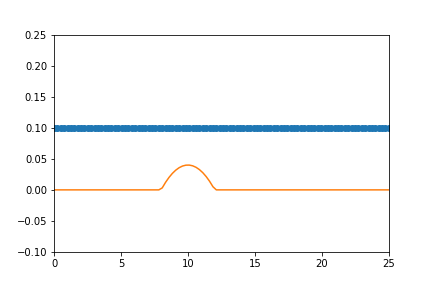
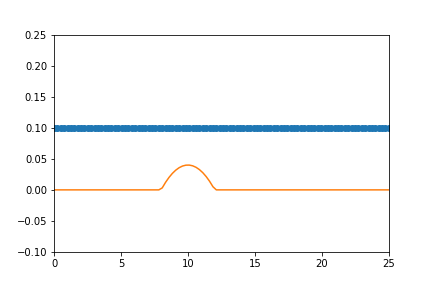
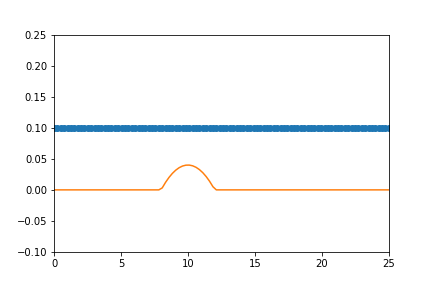
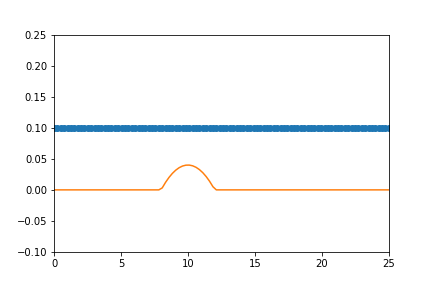
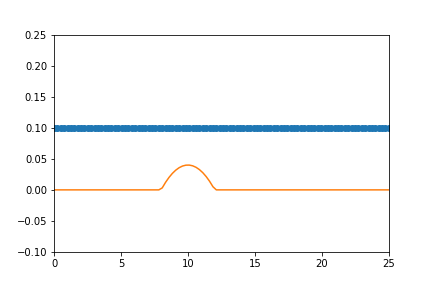
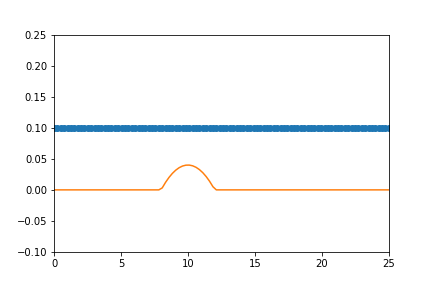
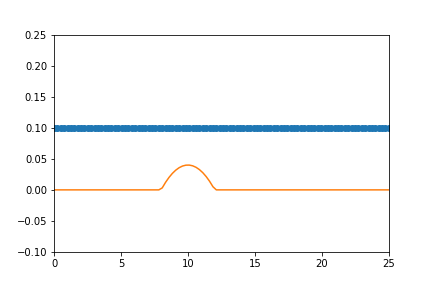
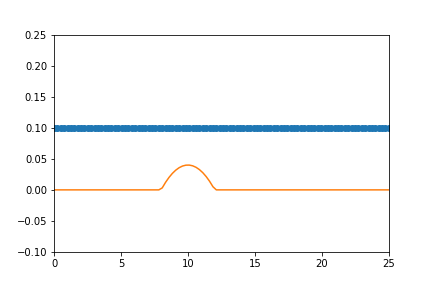
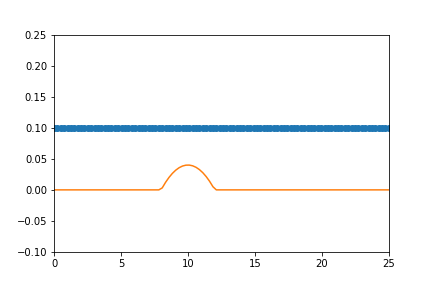
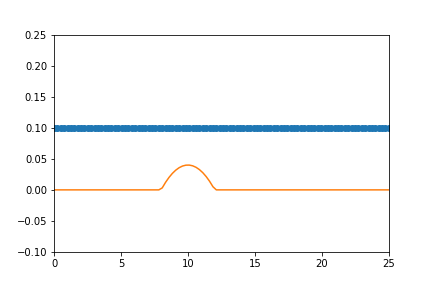

In [23]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(-0.1,0.25))
line, = ax.plot([], [], '-o',lw=2)
lineb, = ax.plot(x,d0)

def animate(i):
    i = min(i*10,nt-1)
    line.set_data(x, h1[i,3:-3]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)

## Subcritical flow over a bump

Section 6.2 in the paper of Berthon an Marche (2008)

### Boundary conditions
A boundary condition based on the characteristics method, as explained in Mignot and Cienfuegos (2011).

In [24]:
#%%writefile nswe_wbmuscl4.py -a 

def bcs_inflow_car(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = hin
    hul = qin
    ul = hul/hl
    hr = h0[3]
    ur = u0[3]
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    
    for i in range(3):
        db[i] = db[3]
        hb[i] = hl
        ub[i] = ul
    
    hr = hin
    ur = qin/hin
    hl = h0[-4]
    ul = u0[-4]

    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)

    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2

    for i in range(3):
        db[-i-1] = db[-4]
        hb[-i-1] = hr
        ub[-i-1] = ur
    
    return db,hb,ub

Same idea but giving explicit values in the boundaries.

In [25]:
#%%writefile nswe_wbmuscl4.py -a 

def bcs_inflow(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    uin = qin/hin
    hb = np.copy(h0)
    ub = np.copy(u0)
    db = np.copy(d)
    for i in range(3):
        db[i] = db[-4]
        hb[i] = hin
        ub[i] = uin
    for i in range(3):
        db[-i-1] = db[-4]
        hb[-i-1] = hin
        ub[-i-1] = uin
    
    return db,hb,ub

### Simulation setup

(0, 2.1)

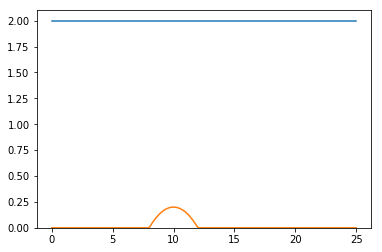

In [26]:
nt = 800
cfl = 1.0
nx = 200
H0 = 2.
q0 = 4.42
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]
d0 = np.where((x<=12.)*(x>=8), 0.2-0.05*(x-10.)**2,0.0)
h0 = H0-d0
hu0 = np.ones_like(x)*q0
u0 = q0/h0
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,2.1)

### Run the simulation and plot results

In [27]:
t200,h200,u200 = wb4.solve_rk4(d0,h0,u0,bcs_inflow,dx,cfl,t0,nt,1e-10,wb4.roe,bcargs=[H0,q0])


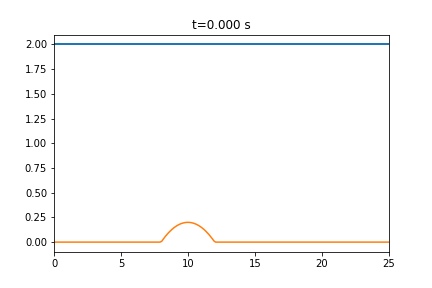
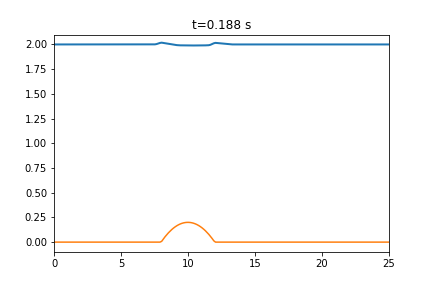
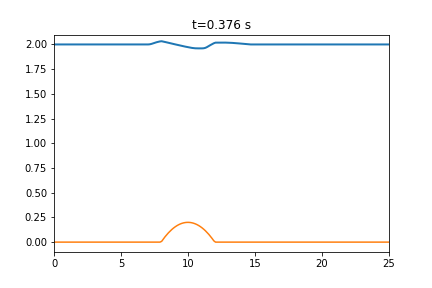
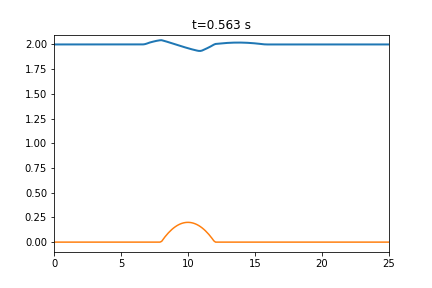
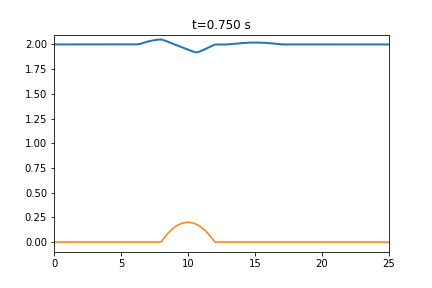
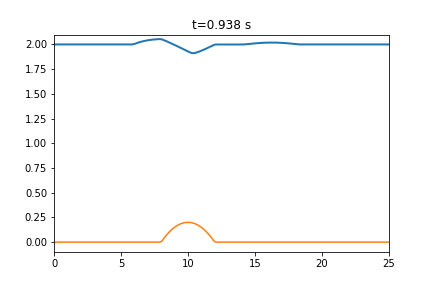
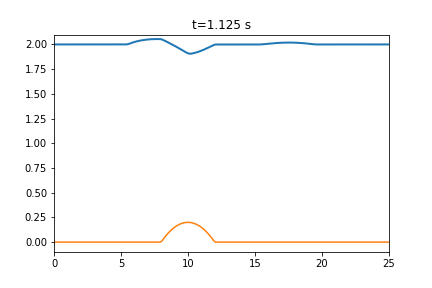
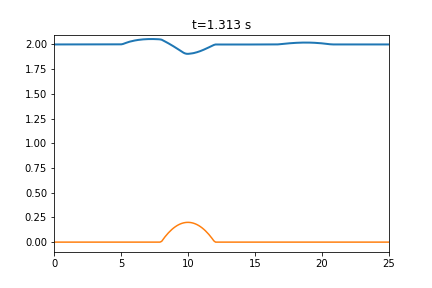
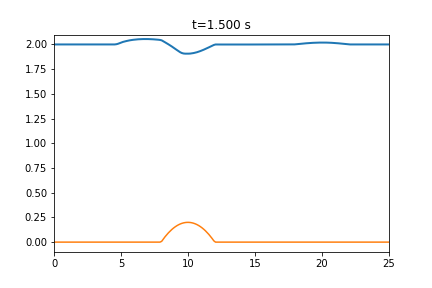
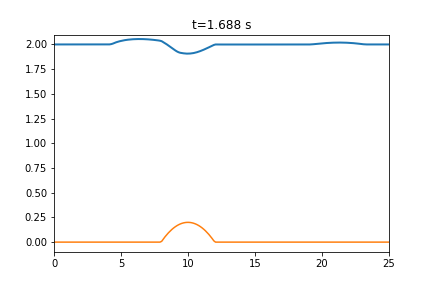
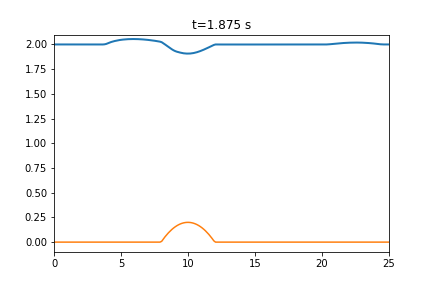
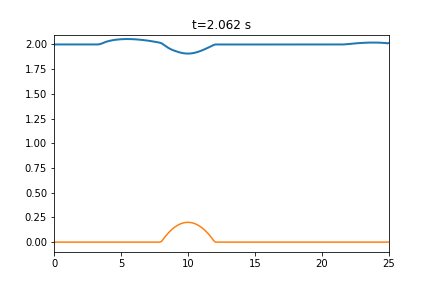
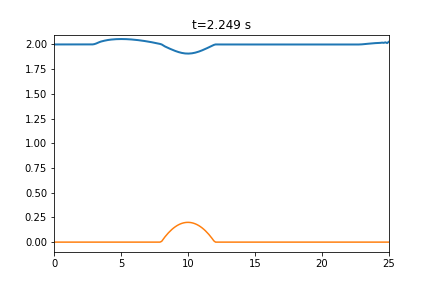
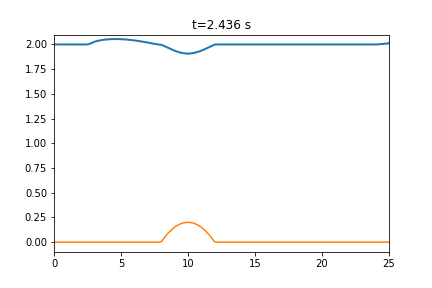
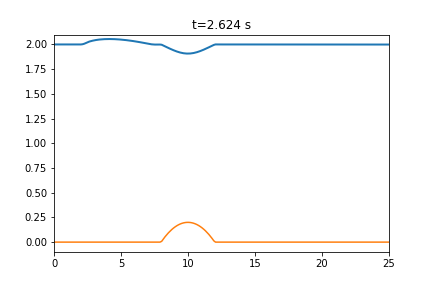
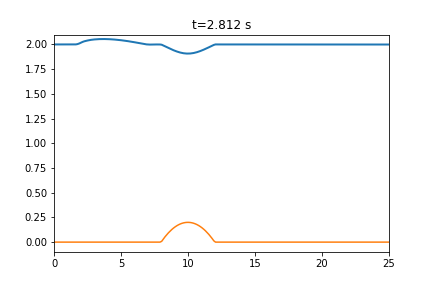
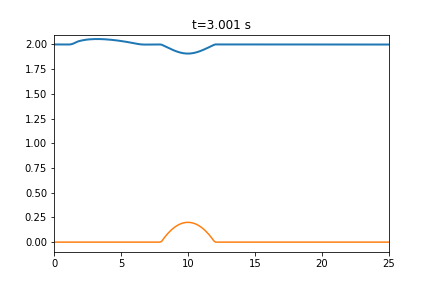
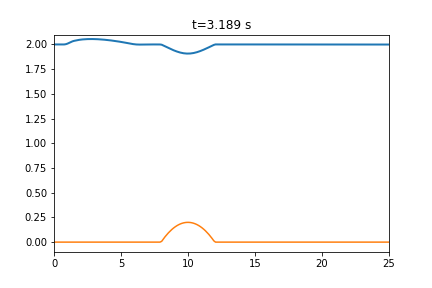
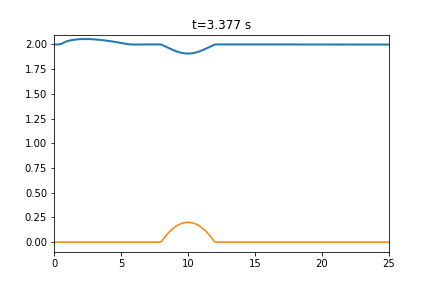
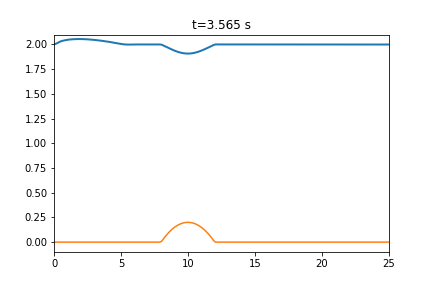
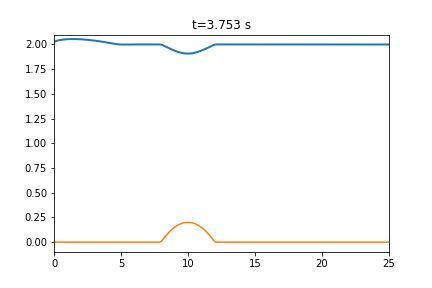
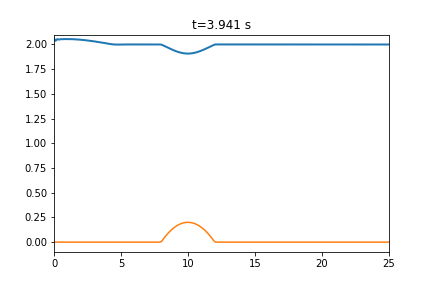
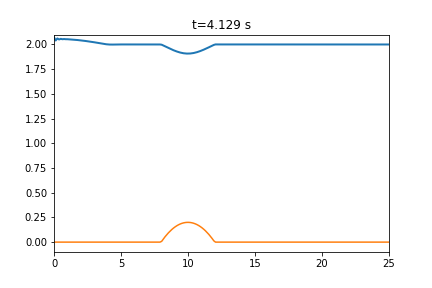
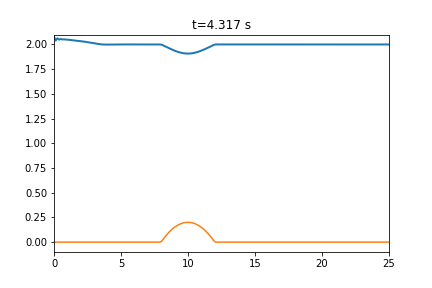
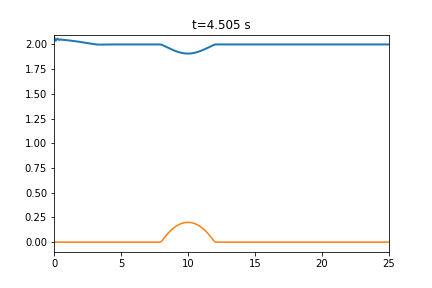
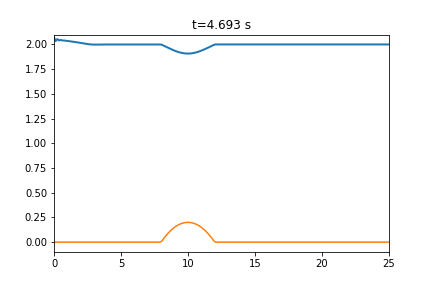
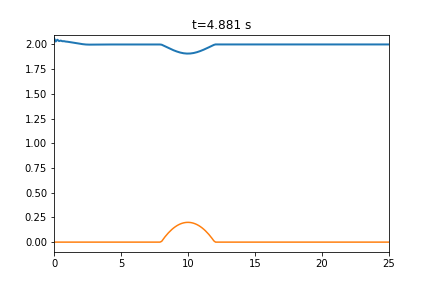
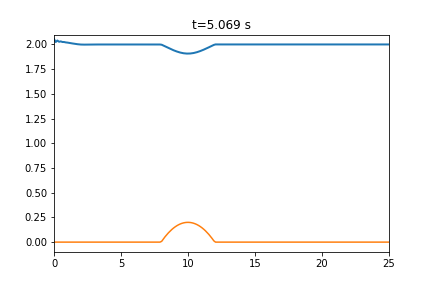
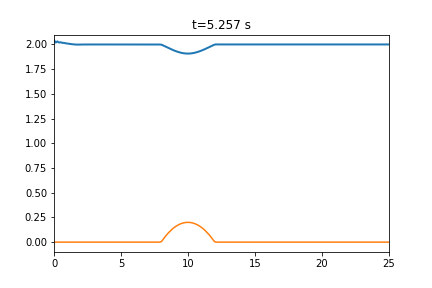
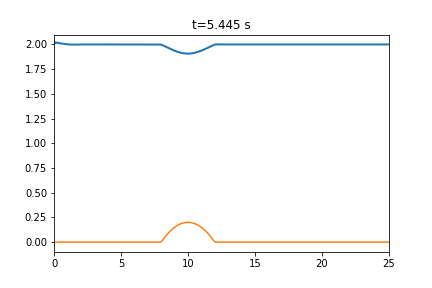
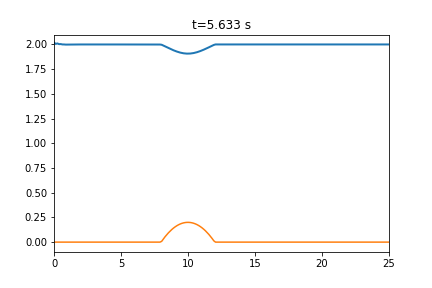
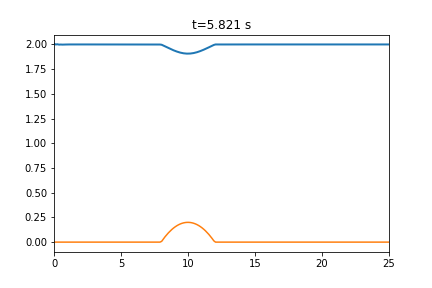
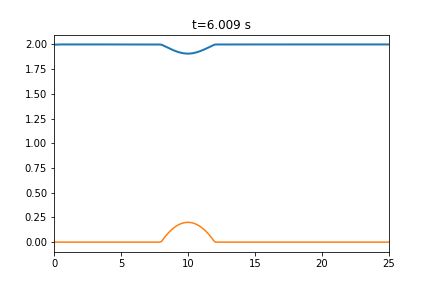
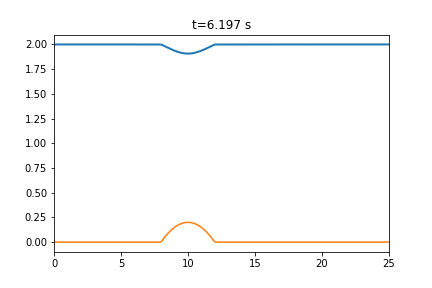
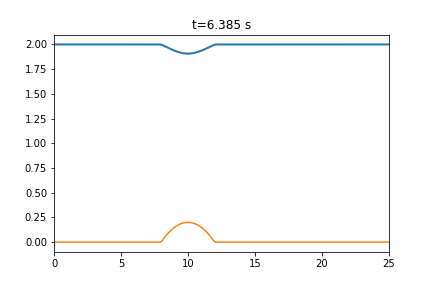
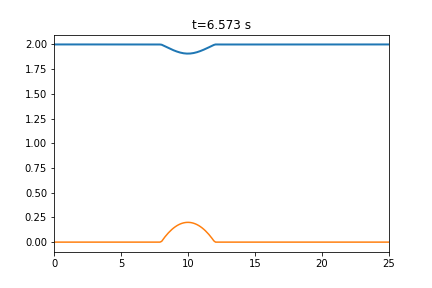
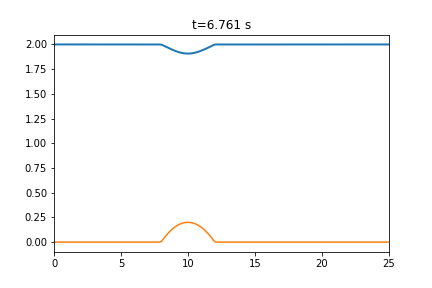
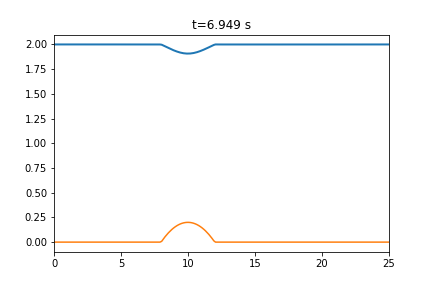
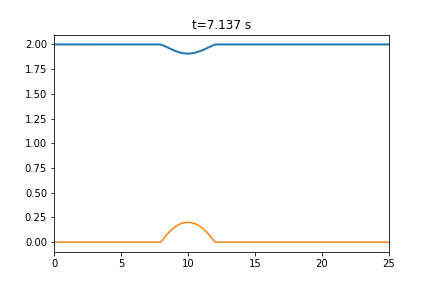
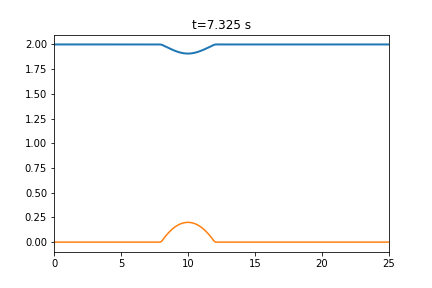
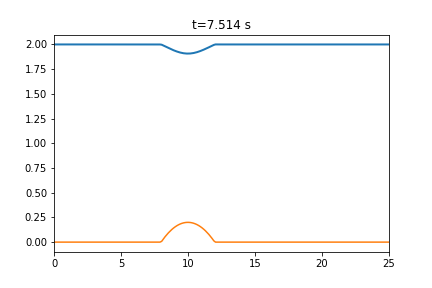
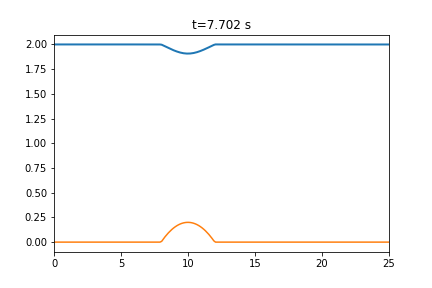
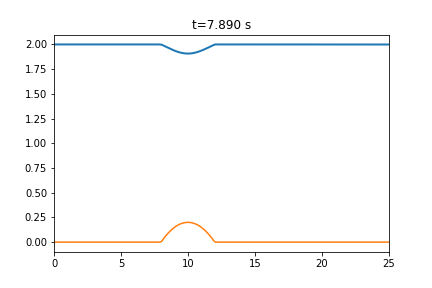
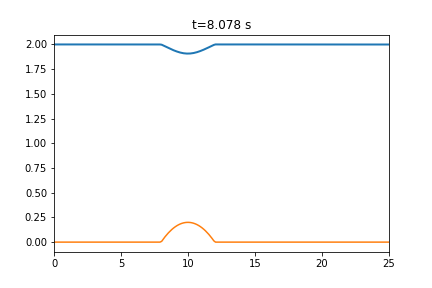
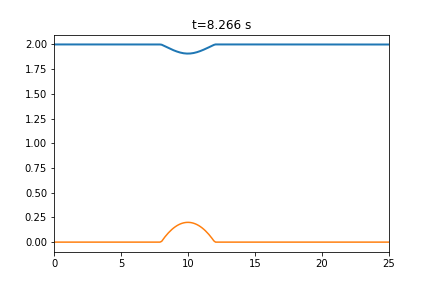
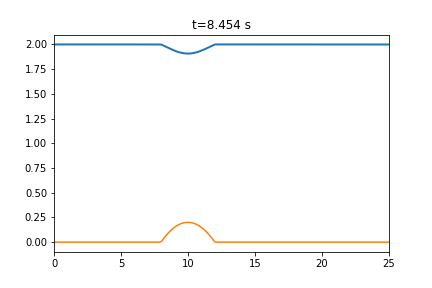
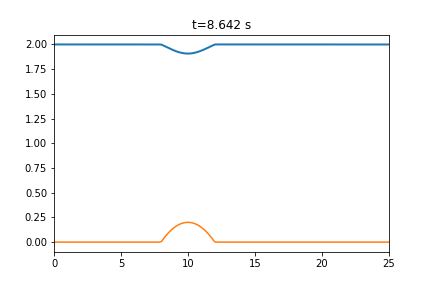
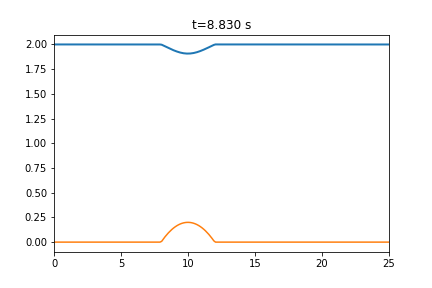
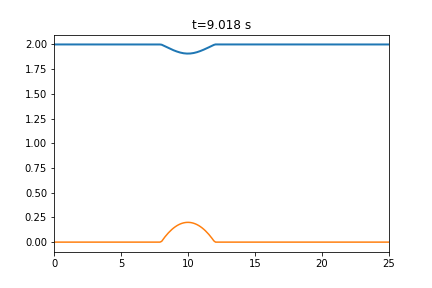
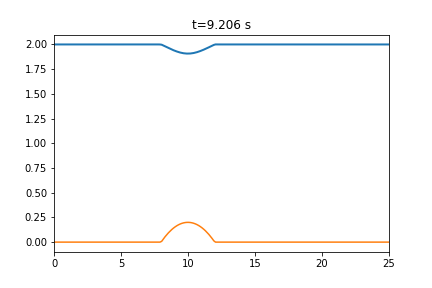
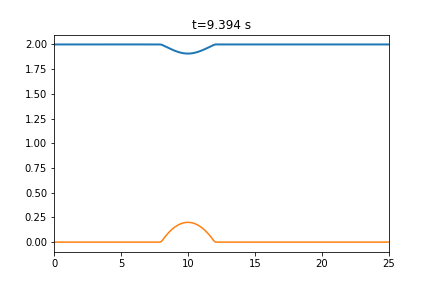
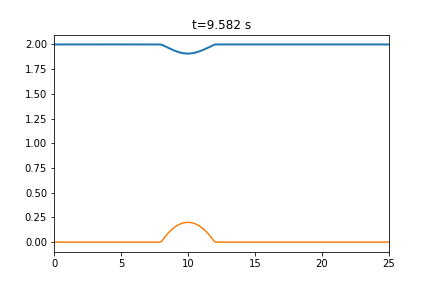
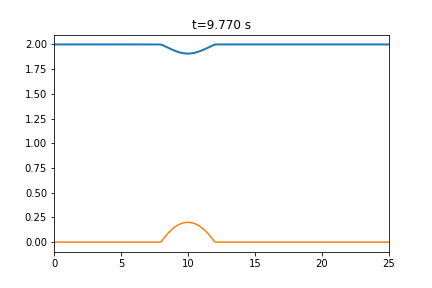
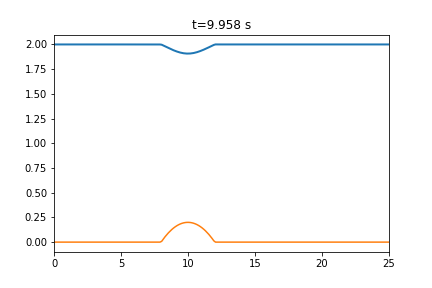
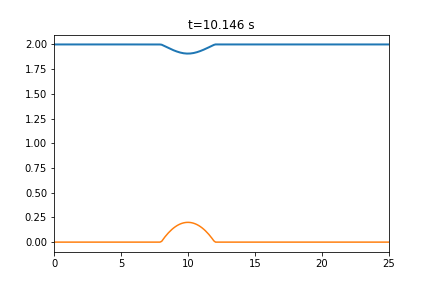
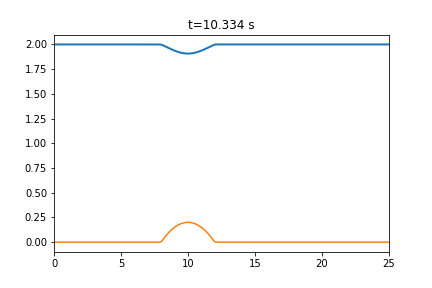
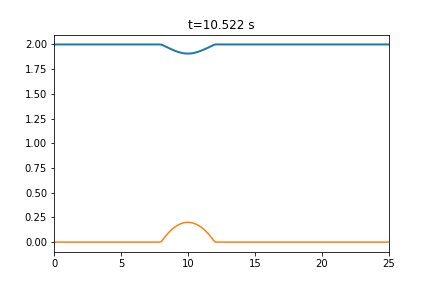
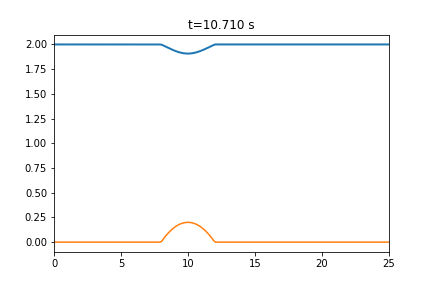
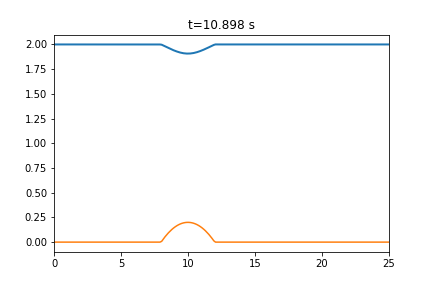
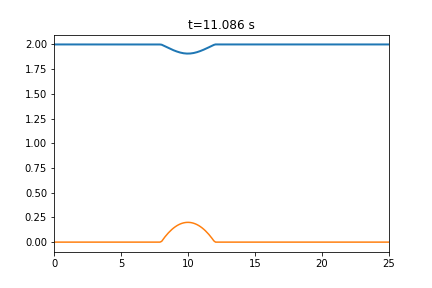
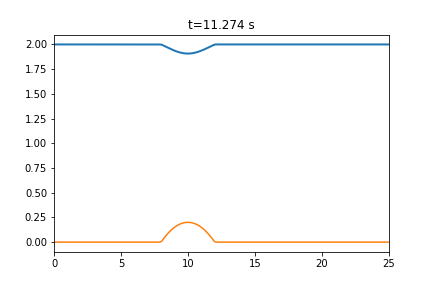
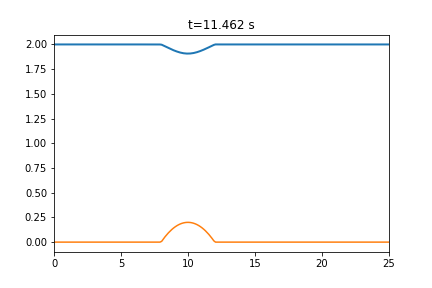
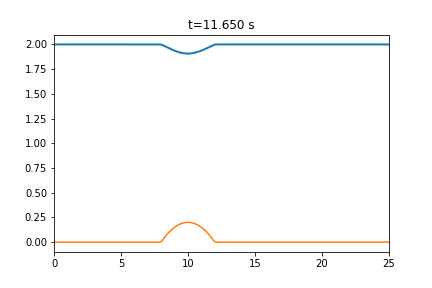
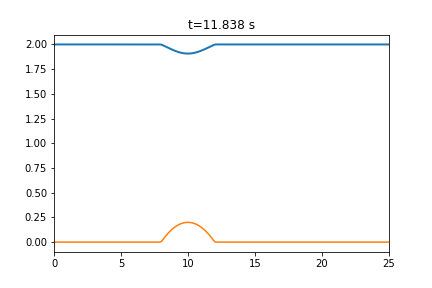
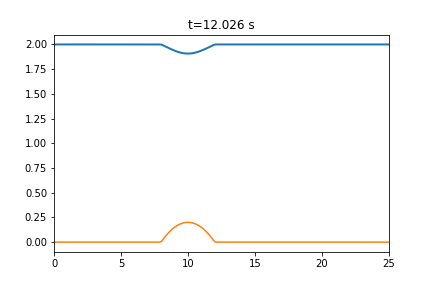
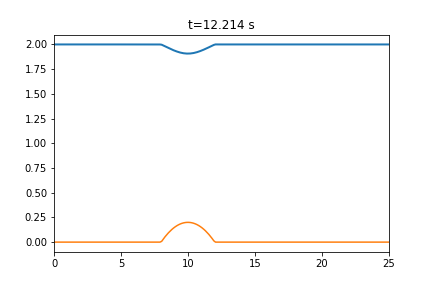
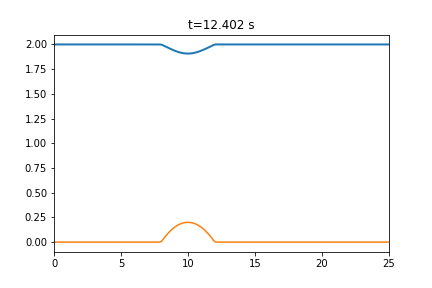
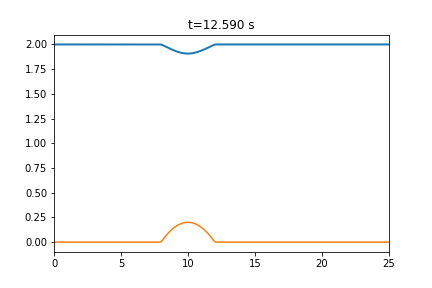
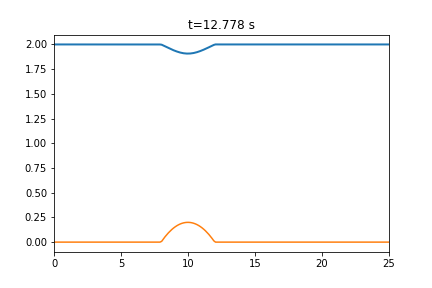
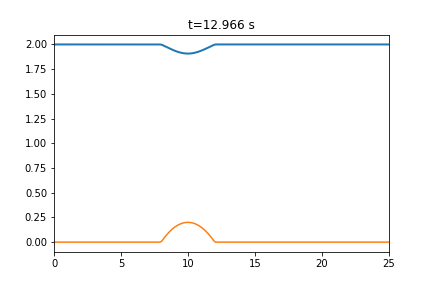
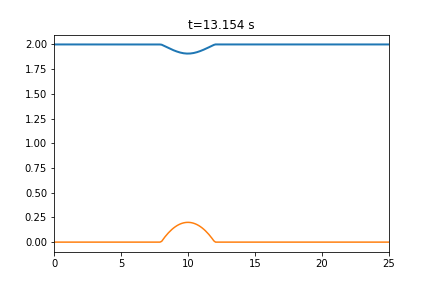
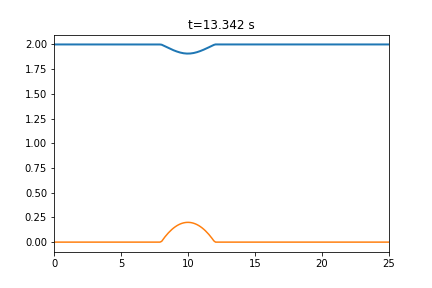
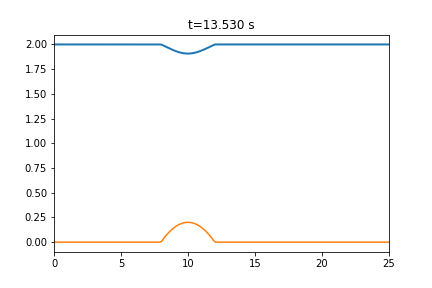
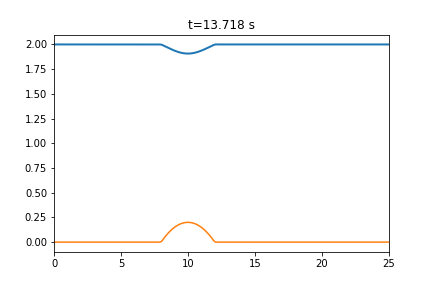
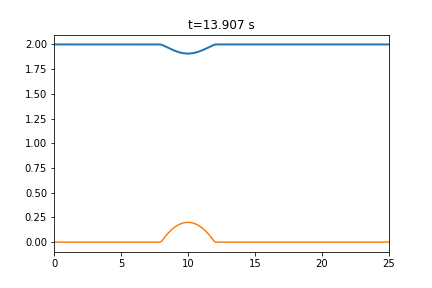
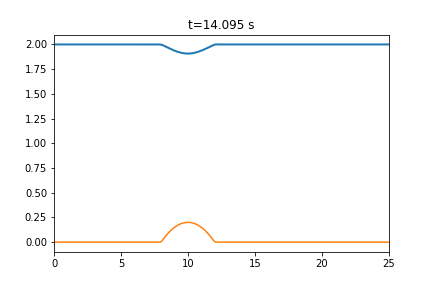
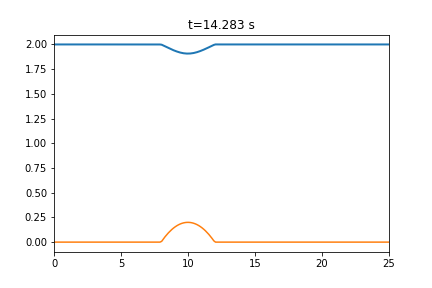
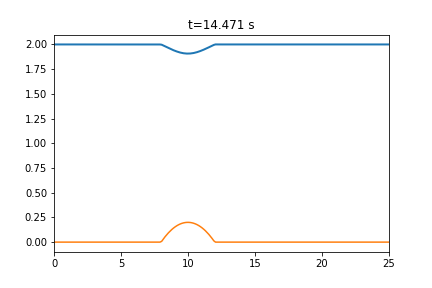
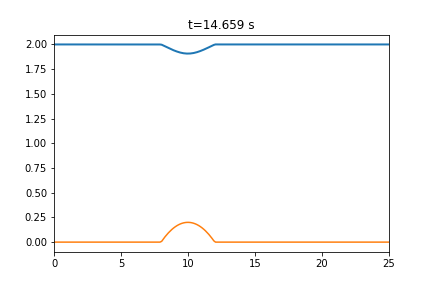
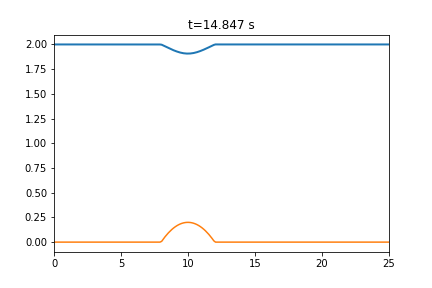

In [28]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(-0.1,2.1))
line, = ax.plot([], [], '-',lw=2)
lineb, = ax.plot(x,d0)
timetxt = ax.set_title('t=')

def animate(i):
    i = min(i*10,nt-1)
    line.set_data(x, h200[i,3:-3]+d0)
    timetxt.set_text('t=%.3f s'%t200[i])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)